In [42]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
START_TOKEN = '<START>'
END_TOKEN = '<END>'

In [9]:
df=pd.read_csv("dump.csv",low_memory=False)

In [10]:
def extract_url(element):
    url=str(element).rsplit("/")
    return url


def extract_host(element):
    host=str(element).rsplit(".")
    return host

In [18]:
data=df.copy()
data['host']=[extract_host(i) for i in data['host']]
data['url']=[extract_url(i) for i in data['url']]
data['host']=[i[::-1] for i in data['host']]
data['message']=data['host']+data['url']
bool_series = pd.notnull(df['label']) 
df=df[bool_series]
y_label= np.array(df['label'].values.astype(int))
print(data['message'][0])

['course', 'safetyserve', 'com', '', 'FineSource', 'elearning', 'courses', 'titles', 'Lib_StoryLineR3CT', 'course_hi_lk', 'story_content', 'slides', '5kFJL7ZUa08.swf']


In [19]:
data['message']=[[START_TOKEN] + [w.lower() for w in list(m)] + [END_TOKEN] for m in data['message']]

In [27]:
def distinct_words(corpus):
    corpus_words = []
    num_corpus_words = -1
    
    corpus_words=[y for x in corpus for y in x]
    corpus_words=sorted(list(set(corpus_words)))
    num_corpus_words=len(corpus_words)

    return corpus_words, num_corpus_words

In [28]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    M=np.zeros([num_words,num_words])
    for sentence in corpus:
        for i,word in enumerate(sentence):
             for j in range(max(i-window_size,0),min(i+window_size+1,len(sentence))):
                    if j!=i and sentence[j] in words:
                        row_index=words.index(word)
                        col_index=words.index(sentence[j])
                        M[row_index][col_index]+=1
                        word2Ind[word]=row_index
    return M, word2Ind

In [29]:
M, word2Ind=compute_co_occurrence_matrix(data['message'])

In [34]:
def reduce_to_k_dim(M, k=2):
    n_iters = 10    
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    svd = TruncatedSVD(n_components=k,n_iter=n_iters)
    M_reduced=svd.fit_transform(M)

    print("Done.")
    return M_reduced

In [36]:
M_reduced=reduce_to_k_dim(M)

Running Truncated SVD over 28323 words...
Done.


In [37]:
def plot_embeddings(M_reduced, word2Ind, words):
    for word in words:
        i=word2Ind[word]
        x = M_reduced[i][0]
        y = M_reduced[i][1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y+0.01, word, fontsize=9)
    plt.show()

In [48]:
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_normalized = M_reduced / M_lengths[:, np.newaxis]

In [54]:
df[df['label']==1]

,dump_id,timestamp,md5,host,url,client,server,size,type,score,tavs,avs,corrupt,vt_query,label
6080,446294,2020-01-07 09:18:45,6d98929faa3fb09e951b0c7f02167356,com.prosystemfx.cdn,/cdn/dcsdata/20191224__16_39_16/2018/US/P/5/FD...,104.207.198.34,72.21.81.200,36602,ZIP,0.0089999996,\N,\N,f,\N,1.0
6081,446292,2020-01-07 09:17:04,4149e9e753dd613ca90f73fdcdaab7ee,com.prosystemfx.cdn,/cdn/dcsdata/20191224__16_39_16/2018/US/P/1/GA...,104.207.198.34,72.21.81.200,129378,ZIP,0.0089999996,\N,\N,f,\N,1.0
6082,446290,2020-01-07 09:16:47,4e45880c1242b01593802d7993b5662f,com.prosystemfx.cdn,/cdn/dcsdata/20191224__16_39_16/2018/US/P/1/FD...,104.207.198.34,72.21.81.200,4487220,ZIP,0.0089999996,\N,\N,f,\N,1.0
6083,446288,2020-01-07 09:16:37,791afd9560ca1c5539e12fa8678f5666,com.prosystemfx.cdn,/cdn/dcsdata/20191223__18_37_05/2018/US/Global...,104.207.198.34,72.21.81.200,1205558,ZIP,0.0089999996,\N,\N,f,\N,1.0
6084,446221,2020-01-06 14:56:03,70940289d79ab2447e49ef7c54cb35e3,com.muscdn.sf19-webcast,/obj/maliva/maliva-live-admin-node/70940289d79...,192.168.16.74,151.101.186.133,140842,ZIP,0.054000001,\N,\N,f,\N,1.0
6085,446225,2020-01-06 14:56:03,70940289d79ab2447e49ef7c54cb35e3,com.muscdn.sf19-webcast,/obj/maliva/maliva-live-admin-node/70940289d79...,104.207.193.98,151.101.186.133,140842,ZIP,0.066,\N,\N,f,\N,1.0
6086,446227,2020-01-06 14:56:03,70940289d79ab2447e49ef7c54cb35e3,com.muscdn.sf19-webcast,/obj/maliva/maliva-live-admin-node/70940289d79...,192.168.16.74,151.101.186.133,140842,ZIP,0.054000001,\N,\N,f,\N,1.0
6087,446228,2020-01-06 14:56:03,f22d20ed8b113d802d42fea2d190714c,com.muscdn.sf19-webcast,/obj/maliva/maliva-live-admin-node/f22d20ed8b1...,192.168.16.74,151.101.186.133,1086578,ZIP,0.054000001,\N,\N,f,\N,1.0
6088,446243,2020-01-06 14:56:03,22a07a221c62e63c12b83bd81cfe69c5,com.muscdn.sf21-webcast,/obj/maliva/maliva-live-admin-node/22a07a221c6...,192.168.16.74,192.229.211.232,5459814,ZIP,0.064000003,\N,\N,f,\N,1.0
6089,446252,2020-01-06 14:56:03,0c062718fdcbe8d1612fe2c8f3fedd83,com.muscdn.sf21-webcast,/obj/maliva/maliva-live-admin-node/0c062718fdc...,192.168.16.74,192.229.211.232,5286863,ZIP,0.027000001,\N,\N,f,\N,1.0


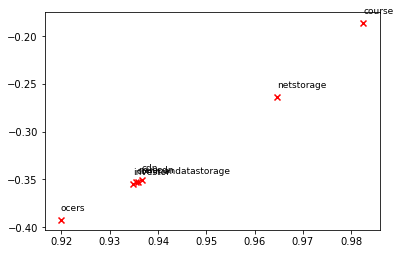

In [58]:
words = ['cdn', 'muscdn', 'commondatastorage', 'investor', 'ocers','course','netstorage']
plot_embeddings(M_normalized, word2Ind, words)

In [55]:
df[df['label']==0]

,dump_id,timestamp,md5,host,url,client,server,size,type,score,tavs,avs,corrupt,vt_query,label
0,454700,2020-01-16 13:22:35,a8a352e94225b9e5ec7d7d289691279f,com.safetyserve.course,/FineSource/elearning/courses/titles/Lib_Story...,10.101.122.109,64.27.100.202,9313,SWF,0,\N,\N,f,\N,0.0
1,454701,2020-01-16 13:22:35,a8a352e94225b9e5ec7d7d289691279f,com.safetyserve.course,/FineSource/elearning/courses/titles/Lib_Story...,64.27.170.66,64.27.100.202,9313,SWF,0,\N,\N,f,\N,0.0
2,454692,2020-01-16 13:18:57,4c89398ec12d4b086ab216c92e42f086,com.safetyserve.course,/FineSource/elearning/courses/titles/Lib_Story...,64.27.170.66,64.27.100.202,10031,SWF,0,\N,\N,f,\N,0.0
3,454693,2020-01-16 13:18:57,4c89398ec12d4b086ab216c92e42f086,com.safetyserve.course,/FineSource/elearning/courses/titles/Lib_Story...,10.101.122.109,64.27.100.202,10031,SWF,0,\N,\N,f,\N,0.0
4,454690,2020-01-16 13:18:00,84bc20024555b4501e1b9c7bed45f59e,com.safetyserve.course,/FineSource/elearning/courses/titles/Lib_Story...,64.27.170.66,64.27.100.202,9040,SWF,0,\N,\N,f,\N,0.0
5,454691,2020-01-16 13:18:00,84bc20024555b4501e1b9c7bed45f59e,com.safetyserve.course,/FineSource/elearning/courses/titles/Lib_Story...,10.101.122.109,64.27.100.202,9040,SWF,0,\N,\N,f,\N,0.0
6,454688,2020-01-16 13:17:27,8460ebbaf2035ca99ebf7737e1f73f3c,com.safetyserve.course,/FineSource/elearning/courses/titles/Lib_Story...,10.101.122.109,64.27.100.202,8177,SWF,0,\N,\N,f,\N,0.0
7,454689,2020-01-16 13:17:27,8460ebbaf2035ca99ebf7737e1f73f3c,com.safetyserve.course,/FineSource/elearning/courses/titles/Lib_Story...,64.27.170.66,64.27.100.202,8177,SWF,0,\N,\N,f,\N,0.0
8,454684,2020-01-16 13:16:50,5b87589fd2377c0318c135849ab1fbaf,com.safetyserve.course,/FineSource/elearning/courses/titles/Lib_Story...,10.101.122.109,64.27.100.202,8900,SWF,0,\N,\N,f,\N,0.0
9,454685,2020-01-16 13:16:50,761be9680b332229f1b04d06433c7d64,com.safetyserve.course,/FineSource/elearning/courses/titles/Lib_Story...,10.101.122.109,64.27.100.202,8932,SWF,0,\N,\N,f,\N,0.0
